### Projet fait en binôme: Mariana DUTRA DINIZ COSTA et Felipe SCHERER VICENTIN

In [1]:
from typing import Union

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

## Simulation of Markov chain

In [2]:
def sample_exp(lamb):
    U = np.random.rand()
    return - np.log(U) / lamb


def sample_class(p: np.array):
    if np.abs(np.sum(p) - 1) > 1e-10:
        p = p / p.sum()
        
    cum_probs = np.cumsum(p)
    U = np.random.rand()
    return np.argmax(U < cum_probs)

In [3]:
def parse_Q(Q):
    diag_Q = np.diagonal(Q)
    
    lambdas = np.abs(diag_Q)
    P = (Q - np.diag(diag_Q)) / lambdas.reshape(N, 1)

    return P, lambdas

In [4]:
def markov_sir(N, beta, gamma, t_max):
    s, i, r = N, 1, 0

    x = [(s, i, r)]
    T = [0]

    for _ in range(t_max):
        if i == 0:
            break
        
        p_new_i = (beta * i * s) / N
        p_new_r = gamma * i
        
        p = np.array([p_new_i, p_new_r])
        # p /= p.sum()
        epsilon = sample_exp(p.sum())

        if sample_class(p) == 0:
            s -= 1
            i += 1
        else:
            i -= 1
            r += 1

        t = T[-1] + epsilon

        x.append((s, i, r))
        T.append(t)

    return np.array(x), np.array(T)

## Simulation of SIR

In [5]:
def create_system(beta, gamma):
    def system(t, y):
        s, i, r = y
        
        ds = -beta * i * s
        di = beta * i * s - gamma * i
        dr = gamma * i
        
        return [ds, di, dr]
        
    return system 

In [6]:
def SIR(N, t_eval, beta, gamma):
    system = create_system(beta, gamma)
    infected = 1
    y0 = [1-infected/N, infected/N, 0]

    sol = solve_ivp(system, (0, t_eval[-1]), y0, t_eval=t_eval)
    
    return sol.y[0], sol.y[1], sol.y[2], sol.t

## Running simulations

In [7]:
def plot_simulation(s_sir, i_sir, r_sir, t_sir, s_markov, i_markov, r_markov, t_markov):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    
    axs[0].plot(t_sir, s_sir, label='susceptible')
    axs[0].plot(t_sir, i_sir, label='infected')
    axs[0].plot(t_sir, r_sir, label='removed')
    axs[0].set_title('Deterministic')
    axs[0].legend()
    
    axs[1].plot(t_markov, s_markov, label='susceptible')
    axs[1].plot(t_markov, i_markov, label='infected')
    axs[1].plot(t_markov, r_markov, label='removed')
    axs[1].set_title('Markovian')
    axs[1].legend()
    
    axs[2].plot(t_markov, i_markov/i_sir, label='infected')
    axs[2].set_title('Ratio')
    axs[2].legend()
    
    fig.suptitle(f'SIR Model {N = }, {beta = }, {gamma = }')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

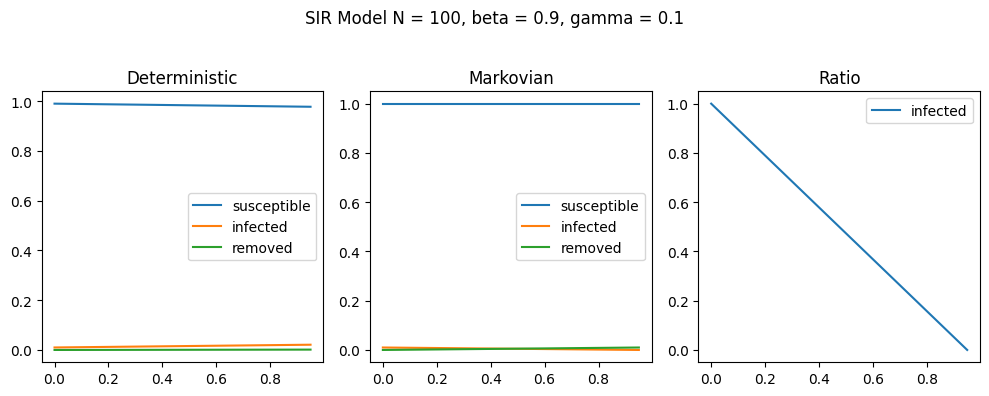

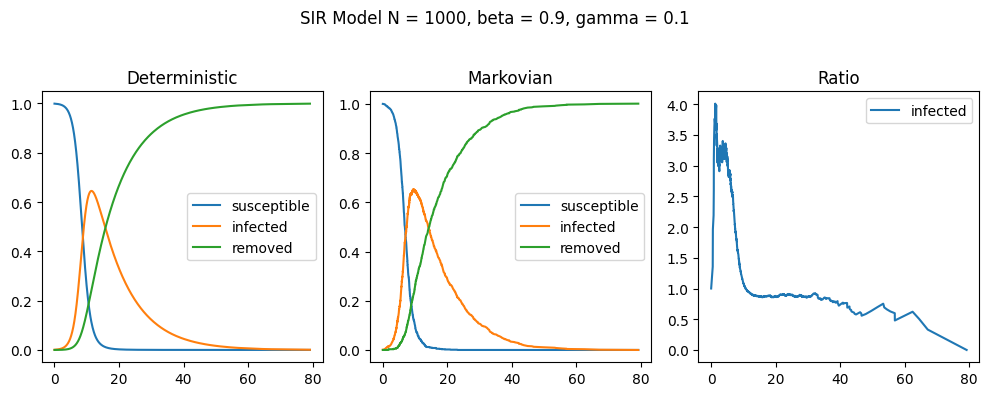

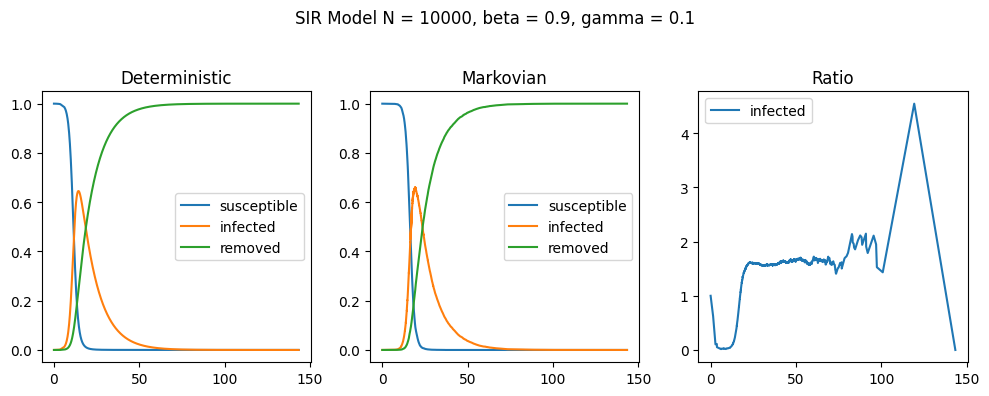

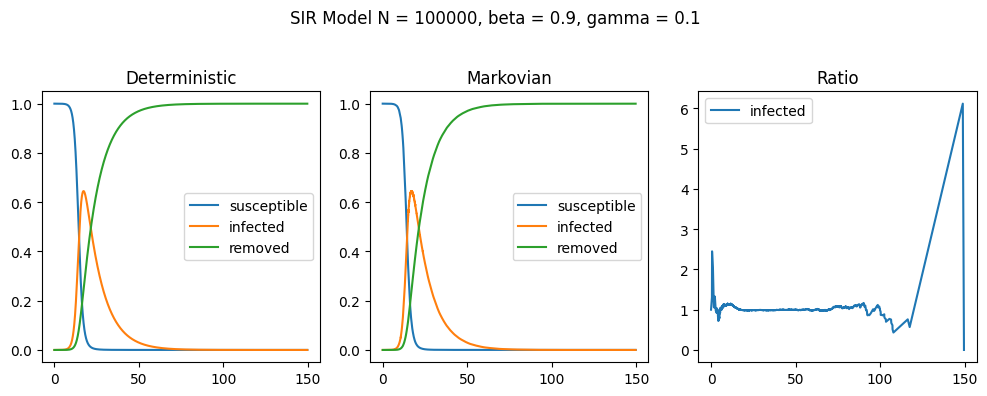

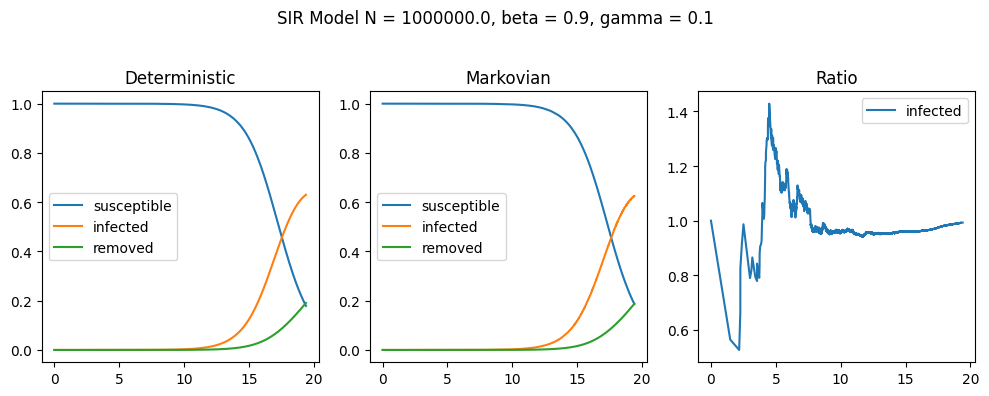

In [23]:
beta = 0.9
gamma = 0.1
T_max = 1_000_000

for N in [1e2, 1e3, 1e4, 1e5, 1e6]:
    x_markov, t_markov = markov_sir(N, beta, gamma, T_max)
    x_markov = x_markov / N

    s_markov, i_markov, r_markov = x_markov[:, 0], x_markov[:, 1], x_markov[:, 2]

    s_sir, i_sir, r_sir, t_sir = SIR(N, t_markov, beta, gamma)

    plot_simulation(s_sir, i_sir, r_sir, t_sir, s_markov, i_markov, r_markov, t_markov)

Couples de valeurs (beta, gamma) ou:
1. Tout le monde est retirée sur le long terme: (0.8, 0.08)
2. Une partie reste susceptible et autre est retirée: (0.8, 0.5)